# TP 5 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [318]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *

In [319]:
from functions import *

In [320]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Restauracion de Imagenes - Trabajo de investigacion

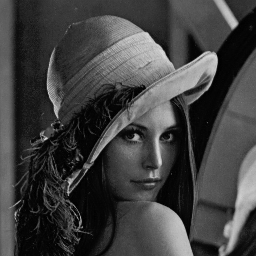

In [321]:
lena = Image.open('img/lena_gray.tif')
w, h = lena.size
displayImage(lena, w//2, h//2)

## 1 - Inverse Filtering
Dado que se conoce la PSF (transformada de Fourier del proceso de degradacion h(x,y)) podemos aplicar el filtro inverso:
\begin{equation*}
    R(\omega_x,\omega_y) = \dfrac{1}{H(\omega_x,\omega_y)}
\end{equation*}

### a - Blur
Obtenemos el efecto de borroso aplicando un filtro pasabajos

In [322]:
def disk(radius):
    N=2*int(radius)+1
    F = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            r2 = (i-N//2)**2 + (j-N//2)**2
            if r2 <= radius**2:
                F[i,j]=1/(np.pi*radius**2)
    return F

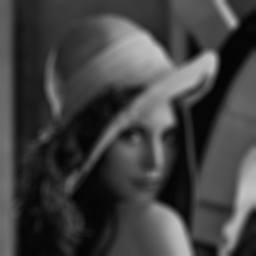

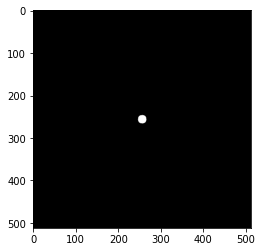

In [353]:
kernel = disk(10)
sz = lena.size  # the sizes we're matching
sz = (sz[0] - kernel.shape[0], sz[1] - kernel.shape[1])  # total amount of padding
kernel = np.pad(kernel, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2, sz[1]//2)), 'constant')
# kernel = np.fft.ifftshift(kernel)


img_filtered = filter2D(src=np.array(lena), ddepth=-1, kernel=kernel)
displayImage_fromcv2(img_filtered, w//2, h//2)
plt.imshow(kernel, cmap='gray')

Aplicamos el filtro inverso

In [332]:
def get_spectrum(img):
    return np.fft.fftshift(np.fft.rfft2(img))
def get_inverse_filter(kernel):
    return 1/get_spectrum(kernel)
def apply_filter(R,G):
    return np.abs(np.fft.ifftshift(np.fft.irfft2(G*R)))

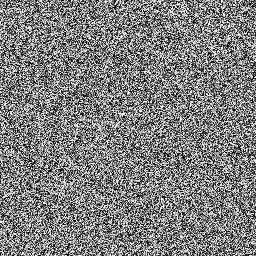

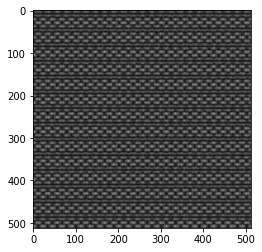

In [354]:
r = get_inverse_filter(kernel)
g = get_spectrum(img_filtered)
image_restored = apply_filter(r,g)
displayImage_fromcv2(image_restored, w//2, h//2)
plt.imshow(image_restored, cmap='gray')